Load or generate data

In [1]:
from ctrl import utils

# data = utils.generate_random_dataset(10, 50)
data = utils.load_data()

Calculate the AC of the three EMI and social company

In [4]:
import numpy as np
from ctrl import discrete_optimal_control as doc

items = data[0]['Xlabs']
intervs = data[0]['Ilabs']
emi_AC = np.zeros((len(data), len(intervs)))

for j in range(len(data)):
    A = data[j]['A']
    B = data[j]['B']
    emi_AC[j] = doc.average_ctrb(A, B=B, T=15)

Test the AC of the three EMI against the AC of social company

In [39]:
from scipy import stats

stats.ttest_ind(emi_AC[:,:3].reshape(-1), emi_AC[:,3])

TtestResult(statistic=2.089010236383041, pvalue=0.04345658140984573, df=38.0)

Plot the AC of EMI and social company (Figure 1a)

C:\Users\janik.fechtelpeter\AppData\Local\Temp\ipykernel_28420\544824073.py:14: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('figures/1a.png')
d:\ZI Mannheim\Control Theory\paper_EMIcompass\code\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


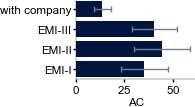

In [32]:
import os
import matplotlib.pyplot as plt
from custom_rcparams_paper import colors

fig, ax = plt.subplots()
ax.barh(range(len(intervs)), emi_AC.mean(axis=0), xerr=stats.sem(emi_AC, axis=0),
        color=colors.ac, ecolor=colors.light_errorbars)
ax.set(yticks=np.arange(len(intervs)),
        yticklabels=intervs,
        xticks=[0,25,50],
        ylim=[-0.5, len(intervs)-0.5],
        xlabel='AC')
utils.set_axis_size(ax, 1.2, 0.8)
plt.savefig('figures/1a.png')

Calculate the AC of hypothetical interventions targeted at single network nodes

In [51]:
node_AC = np.zeros((len(data), len(features)))

for j in range(len(data)):
    A = data[j]['A']
    node_AC[j] = doc.average_ctrb(A, T=15)

### For the right panel: Determine how often each item occurs among the top 4 items w.r.t. average controllability
top4ac = np.r_[np.argsort(node_AC, axis=1)[:,-1:-5:-1].flatten(), np.arange(len(features))].copy()
_, top4ac_counts = np.unique(top4ac, return_counts=True)
top4ac_counts -= 1

Plot the AC of individual nodes and how often the nodes occur in the top 4 AC nodes (Figure 1b)

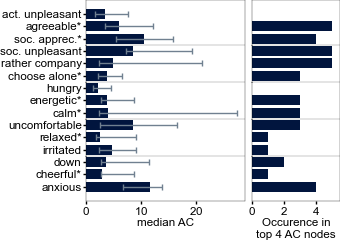

In [52]:
statistic = 'median'

fig, axes = plt.subplots(1,2, figsize=(3.4, 2.4), sharey=True, gridspec_kw={'width_ratios':(1.8,1)})

if statistic=='median':
    interval = np.vstack((np.percentile(node_AC, 25, axis=0), np.percentile(node_AC, 75, axis=0)))
    bar_container = axes[0].barh(range(len(features)), np.median(node_AC, axis=0), color=colors.ac,
            xerr=np.abs(np.median(node_AC, axis=0, keepdims=True)-interval), error_kw={'linewidth':1}, ecolor=colors.light_errorbars)
    axes[0].set_xlabel('median AC')
    axes[0].set_xticks([0,10,20])
elif statistic=='mean':
    interval = stats.sem(node_AC, axis=0)
    bar_container = axes[0].barh(range(len(features)), np.mean(node_AC, axis=0), color=colors.ac,
            xerr=interval, error_kw={'linewidth':1}, ecolor=colors.light_errorbars)
    axes[0].set_xlabel('mean AC')
    axes[0].set_xticks([0,20,40])

axes[0].set_yticks(np.arange(len(features)), labels=features)
axes[0].set_yticks(np.arange(2,len(features)-1,3)+0.5, minor=True)
axes[0].grid(which='minor')

axes[1].barh(range(len(features)), top4ac_counts, color=colors.ac)
axes[1].set_xlabel('Occurence in\ntop 4 AC nodes')
axes[1].set_xticks([0,2,4])
axes[1].set_xlim([0, 5.5])
axes[1].set_yticks(np.arange(2,len(features)-1,3)+0.5, minor=True)
axes[1].grid(which='minor')
axes[1].tick_params(left=False)
plt.savefig('figures/1b.png')


Calculate the correlation between log nodewise AC and log node centrality

In [53]:
from scipy import stats

sum_incoming_weights = np.zeros((len(data), len(features)))
sum_outgoing_weights = np.zeros((len(data), len(features)))

for j in range(len(data)):
    A = data[j]['A']
    sum_incoming_weights[j] = np.sum(np.abs(A), axis=1)     # Incoming weights are rows of A
    sum_outgoing_weights[j] = np.sum(np.abs(A), axis=0)     # Outgoing weights are columns of A
centr = sum_incoming_weights + sum_outgoing_weights

log_node_AC = np.log(node_AC).flatten()
log_centr = np.log(centr).flatten()
correlation_result = stats.pearsonr(log_node_AC, log_centr)

print(f'Correlation of log AC and centrality: {correlation_result}')

Correlation of log AC and centrality: PearsonRResult(statistic=0.7125278187987585, pvalue=1.533859476945158e-24)


Plot log nodewise AC against log node centrality (Figure 1c)

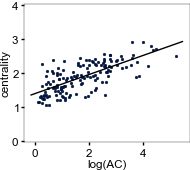

In [57]:
with mpl.rc_context({'lines.markersize':2}):
    fig, ax = plt.subplots(figsize=(1.9,1.7))
    ax, _ = utils.plot_regression(log_node_AC, log_centr, ax=ax,
                        scatter_kwargs={'color':colors.ac}, line_kwargs={'color':'k'})
    ax.set(xlabel='log(AC)',
        ylabel='centrality',
        ylim=np.array(ax.get_ylim()) + np.array([-1, 1]))
    plt.savefig('figures/1c.png')